In [1]:
import pandas as pd
from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
import string
from nltk.stem.porter import PorterStemmer
import re

# Explore Data

In [2]:
reviews = pd.read_json('Health_and_Personal_Care_5.json', lines=True)

In [3]:
reviews['Date'] = pd.to_datetime(reviews['unixReviewTime'],unit='s')

In [4]:
reviews.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,Date
0,159985130X,"[1, 1]",5,This is a great little gadget to have around. ...,"01 5, 2011",ALC5GH8CAMAI7,AnnN,Handy little gadget,1294185600,2011-01-05
1,159985130X,"[1, 1]",4,I would recommend this for a travel magnifier ...,"02 18, 2012",AHKSURW85PJUE,"AZ buyer ""AZ buyer""",Small & may need to encourage battery,1329523200,2012-02-18
2,159985130X,"[75, 77]",4,What I liked was the quality of the lens and t...,"06 8, 2010",A38RMU1Y5TDP9,"Bob Tobias ""Robert Tobias""",Very good but not great,1275955200,2010-06-08
3,159985130X,"[56, 60]",4,Love the Great point light pocket magnifier! ...,"02 8, 2008",A1XZUG7DFXXOS4,Cat lover,great addition to your purse,1202428800,2008-02-08
4,159985130X,"[1, 1]",5,This is very nice. You pull out on the magnifi...,"08 16, 2011",A1MS3M7M7AM13X,Cricketoes,Very nice and convenient.,1313452800,2011-08-16


In [5]:
reviews.shape

(346355, 10)

In [6]:
print("unique products: ", reviews['asin'].nunique())
print("unique users: ", reviews['reviewerID'].nunique())
print("unique reviews: ", reviews['reviewerID'].nunique())
print("timeframe: ", reviews['Date'].min(), " - ", reviews['Date'].max())

unique products:  18534
unique users:  38609
unique reviews:  38609
timeframe:  2000-12-09 00:00:00  -  2014-07-23 00:00:00


In [7]:
# Produts with most reviews
reviews.groupby(['asin']).size().reset_index(name='counts').sort_values('counts',ascending=False).head()

,asin,counts
10706,B0037KMI0U,1089
5308,B0010JLMO8,767
8105,B001KXZ808,699
12260,B0049LUI9O,528
3114,B000GIPJY8,475


In [8]:
# Check NA
reviews.isna().sum()

asin                 0
helpful              0
overall              0
reviewText           0
reviewTime           0
reviewerID           0
reviewerName      3051
summary              0
unixReviewTime       0
Date                 0
dtype: int64

# Data Pre-processing 

In [9]:
# deal with n't
def n_apostrophe_t_handler(document):

    i = 0
    while i < len(document):
        if "n't" in document[i]:        
            # Checks to see if there is a following word after word ending in "n't"
            if (i+1) < len(document):
                document[i+1] = 'not_' + document[i+1]
                document.pop(i)
            else:
                document.pop(i)
        i+=1

    return(document)

In [10]:
# remove numbers
#input_str = ’Box A contains 3 red and 5 white balls, while Box B contains 4 red and 2 blue balls.’
def remove_number(document):
    result = re.sub(r'\d+', '', document)
    return result

In [11]:
# convert text to lower case 
review_text = reviews["reviewText"].str.lower()
print("original: ",review_text[7],"\n")

# remove numbers
review_text = review_text.apply(remove_number)
print("numbers: ",review_text[7],"\n")

# words Tokenization
review_text = review_text.apply(word_tokenize)
print("tokenization: ",review_text[7],"\n")

# deal with negation
review_text = review_text.apply(n_apostrophe_t_handler)
print("negation: ",review_text[7],"\n")

# remove punctuation
punctuations = list(string.punctuation)
review_text = review_text.apply(lambda x: 
           [i.strip("".join(punctuations)) for i in x if i not in punctuations])
print("punctuation: ", review_text[7],"\n")

# remove stop words 
stop_words=set(stopwords.words("english"))
review_text = review_text.apply(lambda x: 
                             [item for item in x if item not in stop_words])
print("stop words: ",review_text[7],"\n")

# word stemming
stemmer = PorterStemmer()
review_text = review_text.apply(lambda x: [stemmer.stem(y) for y in x])
print("stemming:  ",review_text[7],"\n")

# lemmatizer
lemmatizer = WordNetLemmatizer()
review_text = review_text.apply(lambda x: [lemmatizer.lemmatize(y) for y in x])
print("lemmatizer:  ",review_text[7],"\n")

# remove empty string
for i in range(len(review_text)):
    review_text[i] = [x for x in review_text[i] if x]
print("remove empty:  ",review_text[7],"\n")


original:  we bought one for road trips and trying to interpret maps without having to strain our eyes. really nice design, good tactile feel. i couldn't figure out where the batteries were, sent lightwedge customer service an email and received a response within 24 hours. if you need one i'd recommend this one. 

numbers:  we bought one for road trips and trying to interpret maps without having to strain our eyes. really nice design, good tactile feel. i couldn't figure out where the batteries were, sent lightwedge customer service an email and received a response within  hours. if you need one i'd recommend this one. 

tokenization:  ['we', 'bought', 'one', 'for', 'road', 'trips', 'and', 'trying', 'to', 'interpret', 'maps', 'without', 'having', 'to', 'strain', 'our', 'eyes', '.', 'really', 'nice', 'design', ',', 'good', 'tactile', 'feel', '.', 'i', 'could', "n't", 'figure', 'out', 'where', 'the', 'batteries', 'were', ',', 'sent', 'lightwedge', 'customer', 'service', 'an', 'email', 'a

# Text vectorization

## Most frequent words

In [12]:
review_clean = review_text

In [13]:
from nltk import FreqDist
vec=[]
for i in range(len(review_clean)):
    for j in range(len(review_clean[i])):
        vec.append(review_clean[i][j]) 
freq = FreqDist(vec)

In [14]:
most_freq = pd.DataFrame(freq.most_common(500),columns=['Word','Frequency'])
most_freq.head()

,Word,Frequency
0,use,276456
1,product,173446
2,one,144143
3,like,143951
4,work,135202


In [15]:
vocabulary = most_freq['Word'].tolist()

## Clean String

In [16]:
def listToString(s):  
    # initialize an empty string 
    str1 = ""  
    # traverse in the string   
    for ele in s:  
        str1 += ele + " " 
    # return string   
    return str1  


In [17]:
review_clean_str = review_clean.apply(listToString)

## Bag of Words

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(binary=True, vocabulary = vocabulary)
cv.fit(review_clean_str)
X_bow = cv.transform(review_clean_str)

In [19]:
X_bow.toarray().shape

(346355, 500)

In [20]:
bag_of_words_df = pd.DataFrame(X_bow.toarray(), index = reviews['reviewerID'], columns = vocabulary)
bag_of_words_df.head(10)

,use,product,one,like,work,get,take,good,would,great,...,stand,claim,measur,simpli,gone,difficult,absorb,odor,famili,idea
reviewerID,,,,,,,,,,,,,,,,,,,,,
ALC5GH8CAMAI7,1,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
AHKSURW85PJUE,0,0,1,1,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
A38RMU1Y5TDP9,1,0,0,1,1,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
A1XZUG7DFXXOS4,0,0,0,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
A1MS3M7M7AM13X,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
AXO4PQU0XG3TG,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A28X0LT2100RL1,1,0,0,1,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
A1VUSWRVN8SJA8,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
A1JQDCX4LDKBZ3,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


## TF-IDF

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [24]:
tfidf_model = TfidfVectorizer(ngram_range = (1, 1), vocabulary = vocabulary).fit(review_clean_str)

In [25]:
result = pd.DataFrame({'word': tfidf_model.get_feature_names(), 'tfidf': list(tfidf_model.idf_)})

In [27]:
result.head()

,word,tfidf
0,use,1.821326
1,product,2.179951
2,one,2.303672
3,like,2.247320
4,work,2.236394


## n-Grams

In [28]:
tfidf_ngram = TfidfVectorizer(ngram_range = (1, 2), max_features = 1000).fit(review_clean_str)

In [29]:
result2 = pd.DataFrame({'word': tfidf_ngram.get_feature_names(), 'tfidf': list(tfidf_ngram.idf_)})

In [31]:
result2.head()

,word,tfidf
0,abl,4.296929
1,absolut,5.054542
2,absorb,5.095142
3,accur,5.230855
4,acid,5.198424


# Sentiment Analysis

In [21]:
reviews['review_clean_list'] = review_clean
reviews['review_clean_str'] = review_clean_str

In [22]:
from textblob import TextBlob
# get the polarity of each text
reviews['polarity'] = reviews.review_clean_str.map(lambda text: TextBlob(text).sentiment.polarity)

# classify sentiment into positive and negative ones
reviews['sentiment'] = ''
reviews['sentiment'][reviews['polarity'] >= 0] = 'positive'
#test['sentiment'][test['polarity'] == 0] = 'neutral'
reviews['sentiment'][reviews['polarity'] < 0] = 'negative'

D:\Users\dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
D:\Users\dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [23]:
reviews.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,Date,review_clean_list,review_clean_str,polarity,sentiment
0,159985130X,"[1, 1]",5,This is a great little gadget to have around. ...,"01 5, 2011",ALC5GH8CAMAI7,AnnN,Handy little gadget,1294185600,2011-01-05,"[great, littl, gadget, around, alreadi, use, l...",great littl gadget around alreadi use look spl...,0.562500,positive
1,159985130X,"[1, 1]",4,I would recommend this for a travel magnifier ...,"02 18, 2012",AHKSURW85PJUE,"AZ buyer ""AZ buyer""",Small & may need to encourage battery,1329523200,2012-02-18,"[would, recommend, travel, magnifi, occasion, ...",would recommend travel magnifi occasion readin...,0.250000,positive
2,159985130X,"[75, 77]",4,What I liked was the quality of the lens and t...,"06 8, 2010",A38RMU1Y5TDP9,"Bob Tobias ""Robert Tobias""",Very good but not great,1275955200,2010-06-08,"[like, qualiti, len, built, light, len, discer...",like qualiti len built light len discern disto...,0.388725,positive
3,159985130X,"[56, 60]",4,Love the Great point light pocket magnifier! ...,"02 8, 2008",A1XZUG7DFXXOS4,Cat lover,great addition to your purse,1202428800,2008-02-08,"[love, great, point, light, pocket, magnifi, w...",love great point light pocket magnifi work gre...,0.431250,positive
4,159985130X,"[1, 1]",5,This is very nice. You pull out on the magnifi...,"08 16, 2011",A1MS3M7M7AM13X,Cricketoes,Very nice and convenient.,1313452800,2011-08-16,"[nice, pull, magnifi, want, light, come, slide...",nice pull magnifi want light come slide back w...,0.350000,positive


In [24]:
# Sentiment 
reviews.groupby('sentiment').reviewText.count()

sentiment
negative     38790
positive    307565
Name: reviewText, dtype: int64

# Modeling

Develop Sentiment Analysis predictive models (binary classification) in Python, using Jupyter Notebook or any other
tool of your choice. Apply LogisticRegression, SVM, RandomForest classification algorithms (you can also choose any
three classification algorithms of your choice). Apply Data Science Process Model as a guide. (5 points)

In [25]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn import model_selection
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model, datasets
from sklearn.metrics import confusion_matrix

In [26]:
dummy_y = pd.get_dummies(reviews['sentiment'],drop_first=True)   #reduce one degree of freedom
reviews['dummy_y'] = dummy_y

In [27]:
x = bag_of_words_df
y = reviews['dummy_y']
X_train, X_test, y_train, y_test = train_test_split(x, y ,test_size=0.3, random_state=42)

## Logistics Regression

In [28]:
# The default logistic regression
logistic = linear_model.LogisticRegression()
logistic.fit(X_train,y_train)

y_pred = logistic.predict(X_test)
y_score = logistic.predict_proba(X_test)[:,1]

print('Accuracy of logistic regression classifier on test set: {:.5f}'.format(logistic.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.92774


In [45]:
logistic.get_params

<bound method BaseEstimator.get_params of LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)>

In [ ]:
# Tune parameters
import warnings
warnings.filterwarnings("ignore")

params = {'C':[0.0001, 1, 100, 1000],
          'max_iter':[1, 10, 100, 500],
          'class_weight':['balanced', None],
          'solver':['liblinear','sag','lbfgs','newton-cg']
         }
lr = LogisticRegression()
grid_search = GridSearchCV(lr, param_grid=params, cv=10)
grid_search.fit(X_train,y_train)

In [90]:
grid_search.best_params_

{'C': 0.0001, 'class_weight': 'balanced', 'max_iter': 10, 'solver': 'lbfgs'}

In [91]:
# Best logistic model
best_model_log = LogisticRegression(**grid_search.best_params_)
best_model_log.fit(X_train, y_train)

y_pred = best_model_log.predict(X_test)
y_score = best_model_log.predict_proba(X_test)[:,1]

print('Accuracy of best_model_log classifier on test set: {:.5f}'.format(best_model_log.score(X_test, y_test)))

Accuracy of best_model_log classifier on test set: 1.00000


In [47]:
print(confusion_matrix(y_test, y_pred))

[[ 5530  6226]
 [ 1282 90869]]


In [50]:
#Compute precision, recall, F-measure and support
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.47      0.60     11756
           1       0.94      0.99      0.96     92151

    accuracy                           0.93    103907
   macro avg       0.87      0.73      0.78    103907
weighted avg       0.92      0.93      0.92    103907



In [34]:
#roc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
def roc(y_test, y_pred, y_score):
    logit_roc_auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()

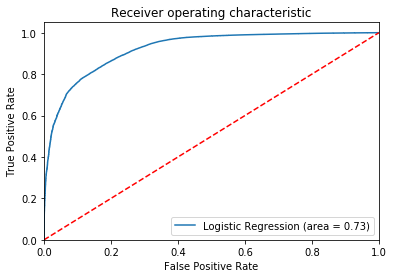

In [52]:
roc(y_test, y_pred, y_score)

## RandomForest

In [29]:
# The default Random Forest
rf_class = RandomForestClassifier()
rf_class.fit(X_train,y_train)

y_pred=rf_class.predict(X_test)
y_score = rf_class.predict_proba(X_test)[:,1]

print('Accuracy of RF classifier on test set: {:.5f}'.format(rf_class.score(X_test, y_test)))

Accuracy of RF classifier on test set: 0.92527


In [ ]:
#Tune parameters
params = {"max_depth": range(10,50,3),
           "n_estimators": range(10,50,3),
           'criterion' :['gini', 'entropy'],
           'max_features': ['auto', 'sqrt', 'log2']
          }
rf = RandomForestClassifier()
grid_search = GridSearchCV(rf, param_grid=params, cv=10)
grid_search.fit(X_train,y_train)

In [26]:
grid_search.best_params_

{'criterion': 'gini',
 'max_depth': 25,
 'max_features': 'sqrt',
 'n_estimators': 22}

In [27]:
# Best RF 
best_model_rf = RandomForestClassifier(**grid_search.best_params_,)
best_model_rf.fit(X_train, y_train)

y_pred = best_model_rf.predict(X_test)
y_score = best_model_rf.predict_proba(X_test)[:,1]

print('Accuracy of best_model_rf classifier on test set: {:.5f}'.format(best_model_rf.score(X_test, y_test)))

Accuracy of best_model_rf classifier on test set: 0.77056


In [30]:
print(confusion_matrix(y_test, y_pred))

[[ 4633  7123]
 [  642 91509]]


In [32]:
#Compute precision, recall, F-measure and support
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.39      0.54     11756
           1       0.93      0.99      0.96     92151

    accuracy                           0.93    103907
   macro avg       0.90      0.69      0.75    103907
weighted avg       0.92      0.93      0.91    103907



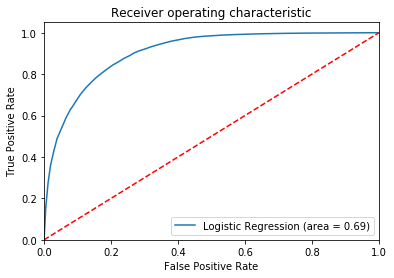

In [35]:
roc(y_test, y_pred, y_score)

## SVM

In [36]:
# The default SVM model
from sklearn import svm

svmclf = svm.SVC()
svmclf.fit(X_train, y_train)

y_pred = svmclf.predict(X_test)
y_score = logistic.predict_proba(X_test)[:,1]

print('Accuracy of SVM classifier on test set: {:.5f}'.format(svmclf.score(X_test, y_test)))

Accuracy of SVM classifier on test set: 0.93281


In [97]:
#Tune parameters
params = [{'kernel': ['rbf'], 'gamma': [0.001, 0.0001],'C': [1, 10, 100, 1000]},
          {'kernel': ['linear'], 'gamma': [0.001, 0.0001], 'C': [1, 10, 100, 1000]}]
svm = svm.SVC()
grid_search = GridSearchCV(svm, param_grid=params, cv=10)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['linear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [98]:
grid_search.best_params_

{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}

In [99]:
# Best svm model
from sklearn import svm
best_model_svm = svm.SVC(**grid_search.best_params_,probability=True)
best_model_svm.fit(X_train, y_train)

y_pred = best_model_svm.predict(X_test)
y_score = best_model_svm.predict_proba(X_test)[:,1]

print('Accuracy of best_model_svm classifier on test set: {:.5f}'.format(best_model_svm.score(X_test, y_test)))

Accuracy of best_model_svm classifier on test set: 1.00000


In [37]:
print(confusion_matrix(y_test, y_pred))

[[ 5997  5759]
 [ 1223 90928]]


In [38]:
#Compute precision, recall, F-measure and support
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.51      0.63     11756
           1       0.94      0.99      0.96     92151

    accuracy                           0.93    103907
   macro avg       0.89      0.75      0.80    103907
weighted avg       0.93      0.93      0.93    103907



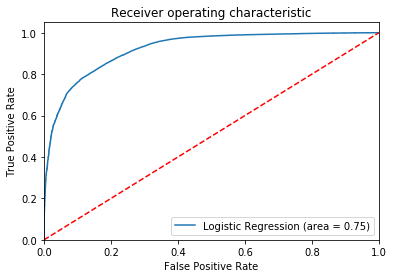

In [39]:
roc(y_test, y_pred, y_score)